# CHM Fractal Analysis: Complete Hypothesis Testing

This notebook performs comprehensive fractal dimension analysis on Canopy Height Models (CHM) to test **all nine research hypotheses** from the Fractal Self-Affinity in Nature framework.

## Five Primary Testable Hypotheses

1. **Optimal Filling** - Old-growth forests maximize light interception, producing higher fractal dimensions
2. **Scale Invariance** - Steady-state forests show scale-invariant gap distributions (power-law decay)
3. **Zeta Distribution** - Canopy gaps follow power-law with exponent α ≈ 2.0, related to ζ(2)
4. **Universal Repulsion** - Dominant tree spacing follows Wigner-Dyson distribution (GUE statistics)
5. **Biotic Decoupling** - Established ecosystems show weak correlation with topographic variables

## Four Additional Spatial Distribution Hypotheses

6. **Fractal String Gap** - Gap sizes follow fractal string spectrum predictions
7. **Prime Number Repulsion (GUE)** - Large tree spacing shows prime-like repulsion patterns
8. **Complex Dimension Oscillation** - Log-periodic oscillations in canopy structure
9. **Riemann Gas Density** - Tree density follows Riemann gas statistical mechanics

## Methods

- **Differential Box Counting (DBC)** - Self-affine fractal dimension of height surfaces
- **Standard Box Counting** - Self-similar fractal dimension comparison  
- **Lacunarity Analysis** - Scale invariance and gap texture
- **Gap Size Distribution** - Power-law vs exponential fitting
- **Nearest Neighbor Spacing** - Wigner-Dyson vs Poisson statistics
- **Topographic Correlation** - DEM-CHM regression analysis

## Requirements

```bash
# Create the environment (first time only)
mamba env create -f environments/3dep-environment.yml

# Install the Jupyter kernel
/opt/conda/envs/3dep/bin/python -m ipykernel install --user --name 3dep --display-name "Python (3DEP)"

# Activate the environment
conda activate 3dep
```

Then select the **"Python (3DEP)"** kernel in Jupyter before running this notebook.

## 1. Environment Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import rioxarray as rio
from pathlib import Path
from datetime import datetime
import json
from scipy import ndimage
from scipy.stats import ks_2samp, chisquare, pearsonr, spearmanr
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree
from scipy.special import zeta
import warnings
warnings.filterwarnings('ignore')

# Interactive mapping
import ipyleaflet
from ipyleaflet import Map, DrawControl, TileLayer, GeoJSON, basemaps
import ipywidgets as widgets
from IPython.display import display

# Geospatial
from shapely.geometry import shape, box, Polygon
from shapely.ops import transform
import pyproj
from rasterio.windows import from_bounds
from rasterio.enums import Resampling

print(f"Environment ready at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Environment ready at 2025-12-22 22:44:20


## 2. Configuration

In [2]:
# Path to CHM raster (update this to your CHM file)
CHM_PATH = Path("/home/jovyan/data-store/data/output/3dep/chm/superior_old_growth_chm.tif")

# Alternative: use a relative path
# CHM_PATH = Path("./outputs/chm/monument_canyon_rna_chm.tif")

# Path to DEM for Hypothesis 5 (Biotic Decoupling)
# Auto-detect: look for _dem.tif in same directory as CHM
_auto_dem_path = CHM_PATH.parent / CHM_PATH.name.replace("_chm.tif", "_dem.tif")
if _auto_dem_path.exists():
    DEM_PATH = _auto_dem_path
    print(f"Auto-detected DEM: {DEM_PATH}")
else:
    # Manual override - set path here if DEM is elsewhere
    DEM_PATH = None  # Path("/path/to/dem.tif")

# Output directory for results
OUTPUT_DIR = Path("/home/jovyan/data-store/data/output/fractal_analysis")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# NoData value (will be read from raster if available)
NODATA_VALUE = -9999

# Gap threshold (meters) - pixels below this are considered "gaps"
GAP_THRESHOLD = 2.0

# Dominant tree detection threshold (meters) - for Hypothesis 4
DOMINANT_TREE_THRESHOLD = 15.0

# Local maxima detection window size (pixels)
LOCAL_MAX_WINDOW = 11

print(f"CHM Path: {CHM_PATH}")
print(f"DEM Path: {DEM_PATH}")
print(f"Output Directory: {OUTPUT_DIR.absolute()}")

Auto-detected DEM: /home/jovyan/data-store/data/output/3dep/chm/superior_old_growth_dem.tif
CHM Path: /home/jovyan/data-store/data/output/3dep/chm/superior_old_growth_chm.tif
DEM Path: /home/jovyan/data-store/data/output/3dep/chm/superior_old_growth_dem.tif
Output Directory: /home/jovyan/data-store/data/output/fractal_analysis


## 3. Load CHM Raster

In [3]:
# Load CHM
print(f"Loading CHM from: {CHM_PATH}")

if not CHM_PATH.exists():
    raise FileNotFoundError(f"CHM file not found: {CHM_PATH}")

chm = rio.open_rasterio(CHM_PATH, masked=True)

# Get NoData value from raster
if chm.rio.nodata is not None:
    NODATA_VALUE = chm.rio.nodata

# Get CRS and bounds
chm_crs = chm.rio.crs
chm_bounds = chm.rio.bounds()

print(f"CHM Shape: {chm.shape}")
print(f"CHM CRS: {chm_crs}")
print(f"CHM Bounds: {chm_bounds}")
print(f"NoData Value: {NODATA_VALUE}")
print(f"Resolution: {chm.rio.resolution()}")

# Basic statistics
chm_data = chm.values.squeeze()
valid_mask = ~np.isnan(chm_data) & (chm_data != NODATA_VALUE)
valid_data = chm_data[valid_mask]

print(f"\nValid pixels: {valid_mask.sum():,} / {chm_data.size:,}")
print(f"Height range: {valid_data.min():.2f} - {valid_data.max():.2f} m")
print(f"Mean height: {valid_data.mean():.2f} m")

Loading CHM from: /home/jovyan/data-store/data/output/3dep/chm/superior_old_growth_chm.tif
CHM Shape: (1, 23285, 17812)
CHM CRS: EPSG:3857
CHM Bounds: (-10027660.03, 6098540.34, -10018754.03, 6110182.84)
NoData Value: nan
Resolution: (0.5, -0.5)

Valid pixels: 358,871,295 / 414,752,420
Height range: -5.31 - 34.01 m
Mean height: 7.47 m


## 4. Interactive AOI Selection

Draw a rectangle on the map to select an Area of Interest (AOI) for analysis.
The AOI will be used to subset the CHM for fractal analysis.

In [4]:
# Transform bounds to WGS84 for Leaflet
def transform_bounds_to_wgs84(bounds, src_crs):
    """Transform bounds from source CRS to WGS84."""
    transformer = pyproj.Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)
    west, south, east, north = bounds
    west_wgs, south_wgs = transformer.transform(west, south)
    east_wgs, north_wgs = transformer.transform(east, north)
    return (west_wgs, south_wgs, east_wgs, north_wgs)

# Get WGS84 bounds
bounds_wgs84 = transform_bounds_to_wgs84(chm_bounds, chm_crs)
center_lat = (bounds_wgs84[1] + bounds_wgs84[3]) / 2
center_lon = (bounds_wgs84[0] + bounds_wgs84[2]) / 2

print(f"CHM bounds (WGS84): {bounds_wgs84}")
print(f"Map center: ({center_lat:.4f}, {center_lon:.4f})")

# Store selected AOI
selected_aoi = {'geometry': None, 'bounds_native': None}

def handle_draw(target, action, geo_json):
    """Handle drawing events from the map."""
    if action == 'created':
        geom = shape(geo_json['geometry'])
        selected_aoi['geometry'] = geom
        
        # Transform to native CRS
        transformer = pyproj.Transformer.from_crs("EPSG:4326", chm_crs, always_xy=True)
        geom_native = transform(transformer.transform, geom)
        selected_aoi['bounds_native'] = geom_native.bounds
        
        print(f"AOI selected!")
        print(f"  WGS84 bounds: {geom.bounds}")
        print(f"  Native CRS bounds: {geom_native.bounds}")

# Create map
m = Map(
    basemap=basemaps.Esri.WorldImagery,
    center=(center_lat, center_lon),
    zoom=14
)

# Add CHM boundary
chm_boundary = {
    "type": "Feature",
    "geometry": {
        "type": "Polygon",
        "coordinates": [[
            [bounds_wgs84[0], bounds_wgs84[1]],
            [bounds_wgs84[2], bounds_wgs84[1]],
            [bounds_wgs84[2], bounds_wgs84[3]],
            [bounds_wgs84[0], bounds_wgs84[3]],
            [bounds_wgs84[0], bounds_wgs84[1]]
        ]]
    },
    "properties": {"name": "CHM Extent"}
}

boundary_layer = GeoJSON(
    data=chm_boundary,
    style={'color': 'yellow', 'weight': 2, 'fillOpacity': 0.0}
)
m.add_layer(boundary_layer)

# Add draw control
draw_control = DrawControl(
    polygon={},
    rectangle={'shapeOptions': {'color': '#00ff00', 'weight': 2}},
    polyline={},
    circle={},
    circlemarker={}
)
draw_control.on_draw(handle_draw)
m.add_control(draw_control)

# Instructions widget
instructions = widgets.HTML(
    value="<b>Instructions:</b> Draw a rectangle on the map to select your AOI. "
          "The yellow boundary shows the CHM extent."
)

display(instructions)
display(m)

CHM bounds (WGS84): (-90.08000268903417, 47.9499981722528, -89.9999987298305, 48.02000043594405)
Map center: (47.9850, -90.0400)


HTML(value='<b>Instructions:</b> Draw a rectangle on the map to select your AOI. The yellow boundary shows the…

Map(center=[47.98499930409842, -90.04000070943233], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [21]:
# Extract CHM subset for selected AOI
# If no AOI selected, use the entire CHM

if selected_aoi['bounds_native'] is not None:
    # Clip to AOI
    west, south, east, north = selected_aoi['bounds_native']
    chm_subset = chm.rio.clip_box(minx=west, miny=south, maxx=east, maxy=north)
    print(f"Using selected AOI")
else:
    # Use entire CHM
    chm_subset = chm
    print(f"No AOI selected - using entire CHM")

# Get the data array
chm_array = chm_subset.values.squeeze().astype(np.float64)

# Create masks
nodata_mask = np.isnan(chm_array) | (chm_array == NODATA_VALUE)
valid_mask = ~nodata_mask

# Get pixel resolution
res_x, res_y = abs(chm_subset.rio.resolution()[0]), abs(chm_subset.rio.resolution()[1])
pixel_resolution = (res_x + res_y) / 2

print(f"\nSubset shape: {chm_array.shape}")
print(f"Valid pixels: {valid_mask.sum():,} ({100*valid_mask.sum()/chm_array.size:.1f}%)")
print(f"NoData pixels: {nodata_mask.sum():,} ({100*nodata_mask.sum()/chm_array.size:.1f}%)")
print(f"Pixel resolution: {pixel_resolution:.3f}m")

Using selected AOI

Subset shape: (1033, 1224)
Valid pixels: 1,112,986 (88.0%)
NoData pixels: 151,406 (12.0%)
Pixel resolution: 0.500m


---

# HYPOTHESIS 1: Optimal Filling

**Prediction:** Old-growth forests "maximize light interception while minimizing self-shading," producing fractal dimensions substantially greater than disturbed or managed stands.

**Method:** Differential Box Counting (DBC) for self-affine surfaces

**Expected Results:**
- D ∈ [2.0, 2.3]: Plantation or young forest (simple structure)
- D ∈ [2.3, 2.5]: Disturbed forest (moderate complexity)
- D ∈ [2.5, 2.8]: Old-growth forest (high complexity)

In [22]:
def differential_box_counting(img, valid_mask, scales=None, min_valid_frac=0.8):
    """
    Compute fractal dimension using Differential Box Counting (Sarkar & Chaudhuri 1994).
    
    Valid range: D in [2, 3]
    - D = 2: Perfectly smooth planar surface
    - D = 3: Maximally rough space-filling surface
    """
    rows, cols = img.shape
    M = min(rows, cols)

    valid_values = img[valid_mask]
    z_min_global, z_max_global = valid_values.min(), valid_values.max()
    z_range_global = z_max_global - z_min_global

    if z_range_global <= 0:
        return np.nan, 0.0, np.array([]), np.array([])

    if scales is None:
        max_scale = M // 4
        scales = [2**i for i in range(1, 10) if 2**i <= max_scale]

    Ns_list = []
    valid_scales = []

    for s in scales:
        nx = cols // s
        ny = rows // s

        if nx < 1 or ny < 1:
            continue

        N_total = 0
        valid_boxes = 0

        for i in range(ny):
            for j in range(nx):
                y_start, y_end = i * s, (i + 1) * s
                x_start, x_end = j * s, (j + 1) * s

                box_data = img[y_start:y_end, x_start:x_end]
                box_valid = valid_mask[y_start:y_end, x_start:x_end]

                valid_frac = box_valid.sum() / (s * s)
                if valid_frac < min_valid_frac:
                    continue

                valid_boxes += 1
                valid_heights = box_data[box_valid]
                z_min_box = valid_heights.min()
                z_max_box = valid_heights.max()

                z_min_scaled = (z_min_box - z_min_global) / z_range_global * M
                z_max_scaled = (z_max_box - z_min_global) / z_range_global * M

                k = int(np.floor(z_min_scaled / s))
                l = int(np.floor(z_max_scaled / s))
                n = l - k + 1

                N_total += n

        if valid_boxes > 0:
            Ns_list.append(N_total)
            valid_scales.append(s)

    if len(valid_scales) < 3:
        return np.nan, 0.0, np.array([]), np.array([])

    log_inv_s = np.log(1.0 / np.array(valid_scales))
    log_Ns = np.log(np.array(Ns_list))

    coeffs = np.polyfit(log_inv_s, log_Ns, 1)
    D = coeffs[0]

    predicted = np.polyval(coeffs, log_inv_s)
    ss_res = np.sum((log_Ns - predicted) ** 2)
    ss_tot = np.sum((log_Ns - np.mean(log_Ns)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

    return D, r2, np.array(valid_scales), np.array(Ns_list)

In [23]:
print("="*70)
print("HYPOTHESIS 1: OPTIMAL FILLING")
print("="*70)
print("\nRunning Differential Box Counting (DBC)...\n")

D_dbc, r2_dbc, scales_dbc, Ns_dbc = differential_box_counting(
    chm_array, valid_mask, min_valid_frac=0.8
)

print(f"\nDBC Fractal Dimension: D = {D_dbc:.4f}")
print(f"R-squared: {r2_dbc:.4f}")

# Classification
if np.isnan(D_dbc):
    h1_classification = "INSUFFICIENT_DATA"
    h1_interpretation = "Insufficient data for analysis"
elif D_dbc >= 2.5:
    h1_classification = "OLD_GROWTH"
    h1_interpretation = f"D = {D_dbc:.2f} suggests OLD GROWTH (high structural complexity)"
elif D_dbc >= 2.3:
    h1_classification = "DISTURBED"
    h1_interpretation = f"D = {D_dbc:.2f} suggests DISTURBED forest (moderate complexity)"
else:
    h1_classification = "PLANTATION"
    h1_interpretation = f"D = {D_dbc:.2f} suggests PLANTATION/Managed (simpler structure)"

print(f"\n{h1_interpretation}")

# Store results
h1_results = {
    'hypothesis': 'H1: Optimal Filling',
    'method': 'Differential Box Counting (DBC)',
    'D_dbc': float(D_dbc) if not np.isnan(D_dbc) else None,
    'r_squared': float(r2_dbc),
    'classification': h1_classification,
    'interpretation': h1_interpretation,
    'supports_hypothesis': h1_classification == 'OLD_GROWTH'
}

HYPOTHESIS 1: OPTIMAL FILLING

Running Differential Box Counting (DBC)...


DBC Fractal Dimension: D = 2.4678
R-squared: 0.9938

D = 2.47 suggests DISTURBED forest (moderate complexity)


---

# HYPOTHESIS 2: Scale Invariance

**Prediction:** Disruption introduces identifiable gap sizes that interrupt scaling patterns, while steady-state forests show "scale invariance (gaps of all sizes following strict power-law decay)."

**Method:** Lacunarity analysis using Gliding Box Algorithm

**Expected Results:**
- High R² (>0.95) in log-log lacunarity plot: Scale invariance (old-growth)
- Moderate R² (0.7-0.95): Partial scale invariance (disturbance recovery)
- Low R² (<0.7): Characteristic scales present (plantation/recent disturbance)

In [24]:
def gliding_box_lacunarity(img, valid_mask, box_sizes=None, min_valid_fraction=0.5):
    """
    Calculate lacunarity using the Gliding Box Algorithm.
    
    Lacunarity: L(r) = (sigma^2 / mu^2) + 1
    Scale invariance: L(r) follows power law in log-log space
    """
    rows, cols = img.shape
    
    img_clean = img.copy()
    img_clean[~valid_mask] = np.nan
    
    if box_sizes is None:
        max_size = min(rows, cols) // 4
        box_sizes = [2**i for i in range(1, 10) if 2**i <= max_size]
    
    lacunarity_values = []
    valid_sizes = []
    
    for r in box_sizes:
        box_sums = []
        
        for i in range(0, rows - r + 1, max(1, r // 2)):
            for j in range(0, cols - r + 1, max(1, r // 2)):
                box = img_clean[i:i+r, j:j+r]
                box_valid = valid_mask[i:i+r, j:j+r]
                
                valid_fraction = box_valid.sum() / (r * r)
                if valid_fraction < min_valid_fraction:
                    continue
                
                box_sum = np.nansum(box)
                box_sums.append(box_sum)
        
        if len(box_sums) < 10:
            continue
        
        box_sums = np.array(box_sums)
        mu = np.mean(box_sums)
        sigma2 = np.var(box_sums)
        
        L = (sigma2 / (mu ** 2)) + 1 if mu > 0 else 1.0
        
        lacunarity_values.append(L)
        valid_sizes.append(r)
    
    if len(valid_sizes) < 2:
        return np.array([]), np.array([]), 0.0, 0.0
    
    log_r = np.log(np.array(valid_sizes))
    log_L = np.log(np.array(lacunarity_values))
    
    coeffs = np.polyfit(log_r, log_L, 1)
    slope = coeffs[0]
    predicted = np.polyval(coeffs, log_r)
    ss_res = np.sum((log_L - predicted) ** 2)
    ss_tot = np.sum((log_L - np.mean(log_L)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    return np.array(lacunarity_values), np.array(valid_sizes), r2, slope

In [25]:
print("="*70)
print("HYPOTHESIS 2: SCALE INVARIANCE")
print("="*70)
print("\nRunning Lacunarity Analysis (Gliding Box Algorithm)...\n")

lacunarity, lac_sizes, r2_lac, lac_slope = gliding_box_lacunarity(chm_array, valid_mask)

print(f"Lacunarity R² (log-log linearity): {r2_lac:.4f}")
print(f"Lacunarity slope: {lac_slope:.4f}")

# Classification
if r2_lac > 0.95:
    h2_classification = "SCALE_INVARIANT"
    h2_interpretation = f"R² = {r2_lac:.2f} -> Strong scale invariance (OLD GROWTH signature)"
elif r2_lac > 0.70:
    h2_classification = "PARTIAL_INVARIANCE"
    h2_interpretation = f"R² = {r2_lac:.2f} -> Moderate scale invariance (DISTURBANCE recovery)"
else:
    h2_classification = "CHARACTERISTIC_SCALES"
    h2_interpretation = f"R² = {r2_lac:.2f} -> Weak scale invariance (PLANTATION or recent disturbance)"

print(f"\n{h2_interpretation}")

h2_results = {
    'hypothesis': 'H2: Scale Invariance',
    'method': 'Lacunarity (Gliding Box)',
    'r_squared': float(r2_lac),
    'slope': float(lac_slope),
    'classification': h2_classification,
    'interpretation': h2_interpretation,
    'supports_hypothesis': h2_classification == 'SCALE_INVARIANT'
}

HYPOTHESIS 2: SCALE INVARIANCE

Running Lacunarity Analysis (Gliding Box Algorithm)...

Lacunarity R² (log-log linearity): 0.9772
Lacunarity slope: -0.0695

R² = 0.98 -> Strong scale invariance (OLD GROWTH signature)


---

# HYPOTHESIS 3: Zeta Distribution

**Prediction:** Canopy gaps in mature forests follow a power-law distribution where the exponent approximately equals 2.0, "related to ζ(2)," connecting to mathematical packing theory.

**Method:** Gap size distribution fitting (power-law vs exponential)

**Expected Results:**
- Power-law with α ≈ 2.0: Old-growth (optimal packing, related to ζ(2) = π²/6)
- Power-law with α ≠ 2.0: Disturbance-modified gap dynamics
- Exponential distribution: Plantation or uniform management

In [ ]:
def identify_gaps(chm, valid_mask, gap_threshold=2.0, min_gap_size=1):
    """Identify contiguous gap regions in the CHM."""
    gap_mask = (chm < gap_threshold) & valid_mask
    labeled, num_features = ndimage.label(gap_mask)
    gap_areas = ndimage.sum(gap_mask, labeled, range(1, num_features + 1))
    gap_areas = gap_areas[gap_areas >= min_gap_size]
    return gap_areas, labeled


def fit_gap_distribution(gap_areas, resolution=1.0, min_fit_area=1.0):
    """Fit power law and exponential distributions to gap sizes.
    
    Args:
        gap_areas: Array of gap areas in pixels
        resolution: Pixel resolution in meters
        min_fit_area: Minimum area threshold (m²) for curve fitting to avoid bias from small gaps
    """
    areas = gap_areas * (resolution ** 2)
    areas = areas[areas > 0]
    
    if len(areas) < 10:
        return {'error': 'Insufficient gaps for analysis'}
    
    # Overall statistics use all gaps
    sorted_areas = np.sort(areas)
    ecdf = np.arange(1, len(sorted_areas) + 1) / len(sorted_areas)
    ccdf = 1 - ecdf
    
    # Filter for minimum area threshold for fitting
    fit_mask = sorted_areas >= min_fit_area
    if np.sum(fit_mask) < 10:
        return {'error': f'Insufficient gaps >= {min_fit_area} m² for fitting'}
    
    fit_areas = sorted_areas[fit_mask]
    fit_ccdf = ccdf[fit_mask]
    
    # Power law fit (using gaps >= min_fit_area)
    try:
        mask = fit_ccdf > 0.01
        log_x = np.log(fit_areas[mask])
        log_ccdf = np.log(fit_ccdf[mask])
        
        pl_coeffs = np.polyfit(log_x, log_ccdf, 1)
        alpha_pl = -pl_coeffs[0] + 1
        
        predicted_pl = np.polyval(pl_coeffs, log_x)
        ss_res_pl = np.sum((log_ccdf - predicted_pl) ** 2)
        ss_tot = np.sum((log_ccdf - np.mean(log_ccdf)) ** 2)
        r2_pl = 1 - (ss_res_pl / ss_tot) if ss_tot > 0 else 0
    except:
        alpha_pl = np.nan
        r2_pl = 0
    
    # Exponential fit (using gaps >= min_fit_area)
    try:
        x_vals = fit_areas[mask]
        log_ccdf_exp = np.log(fit_ccdf[mask])
        
        exp_coeffs = np.polyfit(x_vals, log_ccdf_exp, 1)
        beta_exp = -exp_coeffs[0]
        
        predicted_exp = np.polyval(exp_coeffs, x_vals)
        ss_res_exp = np.sum((log_ccdf_exp - predicted_exp) ** 2)
        r2_exp = 1 - (ss_res_exp / ss_tot) if ss_tot > 0 else 0
    except:
        beta_exp = np.nan
        r2_exp = 0
    
    return {
        'n_gaps': len(areas),
        'n_gaps_fitted': int(np.sum(fit_mask)),
        'min_fit_area': min_fit_area,
        'min_area': areas.min(),
        'max_area': areas.max(),
        'median_area': np.median(areas),
        'power_law': {'alpha': alpha_pl, 'r2': r2_pl},
        'exponential': {'beta': beta_exp, 'r2': r2_exp},
        'zeta_2': np.pi**2 / 6,
        'sorted_areas': sorted_areas,
        'ccdf': ccdf
    }

In [ ]:
print("="*70)
print("HYPOTHESIS 3: ZETA DISTRIBUTION")
print("="*70)
print("\nRunning Gap Size Distribution Analysis...\n")

gap_areas, labeled_gaps = identify_gaps(chm_array, valid_mask, GAP_THRESHOLD)
gap_results = fit_gap_distribution(gap_areas, pixel_resolution, min_fit_area=1.0)

if 'error' in gap_results:
    print(f"Error: {gap_results['error']}")
    h3_classification = "INSUFFICIENT_DATA"
    h3_interpretation = gap_results['error']
else:
    print(f"Total gaps identified: {gap_results['n_gaps']}")
    print(f"Gaps used for fitting (>= {gap_results['min_fit_area']} m²): {gap_results['n_gaps_fitted']}")
    print(f"Gap area range: {gap_results['min_area']:.2f} - {gap_results['max_area']:.2f} m²")
    print(f"\nPower Law Fit (gaps >= {gap_results['min_fit_area']} m²):")
    print(f"  α (exponent): {gap_results['power_law']['alpha']:.4f}")
    print(f"  R²: {gap_results['power_law']['r2']:.4f}")
    print(f"\nExponential Fit:")
    print(f"  R²: {gap_results['exponential']['r2']:.4f}")
    print(f"\nZeta Connection:")
    print(f"  ζ(2) = π²/6 ≈ {gap_results['zeta_2']:.4f}")
    print(f"  |α - 2| = {abs(gap_results['power_law']['alpha'] - 2.0):.4f}")
    
    pl_r2 = gap_results['power_law']['r2']
    exp_r2 = gap_results['exponential']['r2']
    alpha = gap_results['power_law']['alpha']
    
    if pl_r2 > exp_r2 and pl_r2 > 0.8:
        if 1.8 <= alpha <= 2.2:
            h3_classification = "ZETA_DISTRIBUTED"
            h3_interpretation = f"Power law α ≈ {alpha:.2f} close to 2.0 -> OLD GROWTH signature"
        else:
            h3_classification = "POWER_LAW_MODIFIED"
            h3_interpretation = f"Power law α = {alpha:.2f} deviates from 2.0 -> DISTURBANCE modified"
    else:
        h3_classification = "EXPONENTIAL"
        h3_interpretation = f"Exponential fits better (R²={exp_r2:.2f}) -> PLANTATION signature"
    
    print(f"\n{h3_interpretation}")

h3_results = {
    'hypothesis': 'H3: Zeta Distribution',
    'method': 'Gap Size Distribution',
    'n_gaps': gap_results.get('n_gaps', 0),
    'n_gaps_fitted': gap_results.get('n_gaps_fitted', 0),
    'min_fit_area': gap_results.get('min_fit_area', 1.0),
    'power_law_alpha': float(gap_results.get('power_law', {}).get('alpha', np.nan)),
    'power_law_r2': float(gap_results.get('power_law', {}).get('r2', 0)),
    'exponential_r2': float(gap_results.get('exponential', {}).get('r2', 0)),
    'zeta_2': float(np.pi**2 / 6),
    'alpha_deviation_from_2': float(abs(gap_results.get('power_law', {}).get('alpha', 0) - 2.0)),
    'classification': h3_classification,
    'interpretation': h3_interpretation,
    'supports_hypothesis': h3_classification == 'ZETA_DISTRIBUTED'
}

---

# HYPOTHESIS 4: Universal Repulsion

**Prediction:** Dominant tree apex spacing matches the Wigner-Dyson distribution, indicating "rigid repulsion rather than random Poisson placement" consistent with random matrix statistics.

**Method:** Nearest neighbor spacing distribution of tree tops

**Expected Results:**
- Wigner-Dyson (GUE): P(s) ~ s² exp(-4s²/π) -> Repulsion (competition-structured, old-growth)
- Poisson: P(s) ~ exp(-s) -> Random placement (young or disturbed forest)
- Clustering: Peak at small s -> Regeneration patches

In [28]:
def detect_local_maxima(img, valid_mask, window_size=11, height_threshold=15.0):
    """
    Detect local maxima (tree tops) in the CHM.
    
    Returns coordinates of dominant tree apices.
    """
    # Apply height threshold
    img_masked = np.where(valid_mask & (img >= height_threshold), img, -np.inf)
    
    # Find local maxima using maximum filter
    local_max = ndimage.maximum_filter(img_masked, size=window_size)
    is_peak = (img_masked == local_max) & (img_masked > -np.inf)
    
    # Get coordinates
    peak_coords = np.array(np.where(is_peak)).T  # (N, 2) array of (row, col)
    peak_heights = img[is_peak]
    
    return peak_coords, peak_heights


def wigner_dyson_gue(s):
    """Wigner-Dyson distribution for GUE (Gaussian Unitary Ensemble)."""
    return (32 / np.pi**2) * s**2 * np.exp(-4 * s**2 / np.pi)


def poisson_spacing(s):
    """Poisson (random) spacing distribution."""
    return np.exp(-s)


def compute_nearest_neighbor_spacing(coords, resolution=1.0):
    """
    Compute nearest neighbor spacing distribution.
    
    Returns normalized spacings (s = spacing / mean_spacing).
    """
    if len(coords) < 10:
        return np.array([]), 0.0
    
    # Convert to physical coordinates
    coords_physical = coords * resolution
    
    # Build KD-tree
    tree = cKDTree(coords_physical)
    
    # Find nearest neighbor distances (k=2 because first is self)
    distances, _ = tree.query(coords_physical, k=2)
    nn_distances = distances[:, 1]  # Second column is nearest neighbor
    
    # Normalize by mean spacing
    mean_spacing = np.mean(nn_distances)
    normalized_spacings = nn_distances / mean_spacing
    
    return normalized_spacings, mean_spacing


def fit_spacing_distribution(spacings):
    """
    Compare spacing distribution to Wigner-Dyson and Poisson.
    
    Uses Kolmogorov-Smirnov test.
    """
    if len(spacings) < 10:
        return {'error': 'Insufficient trees for analysis'}
    
    # Create empirical histogram
    s_range = np.linspace(0.01, 3.0, 100)
    
    # Generate theoretical samples
    n_samples = len(spacings) * 10
    
    # Wigner-Dyson samples (inverse transform sampling approximation)
    # Using rejection sampling
    wd_samples = []
    while len(wd_samples) < n_samples:
        s = np.random.uniform(0, 4, 1000)
        p = wigner_dyson_gue(s)
        accept = np.random.uniform(0, 1, 1000) < p / 0.5  # 0.5 is approx max
        wd_samples.extend(s[accept].tolist())
    wd_samples = np.array(wd_samples[:n_samples])
    
    # Poisson samples
    poisson_samples = np.random.exponential(1.0, n_samples)
    
    # KS tests
    ks_wd, p_wd = ks_2samp(spacings, wd_samples)
    ks_poisson, p_poisson = ks_2samp(spacings, poisson_samples)
    
    # Compute histogram for visualization
    hist, bin_edges = np.histogram(spacings, bins=30, density=True, range=(0, 3))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    return {
        'n_trees': len(spacings),
        'ks_wigner_dyson': ks_wd,
        'p_wigner_dyson': p_wd,
        'ks_poisson': ks_poisson,
        'p_poisson': p_poisson,
        'histogram': hist,
        'bin_centers': bin_centers,
        'spacings': spacings
    }

In [29]:
print("="*70)
print("HYPOTHESIS 4: UNIVERSAL REPULSION")
print("="*70)
print("\nDetecting dominant tree apices...\n")

# Detect tree tops
tree_coords, tree_heights = detect_local_maxima(
    chm_array, valid_mask, 
    window_size=LOCAL_MAX_WINDOW, 
    height_threshold=DOMINANT_TREE_THRESHOLD
)

print(f"Dominant trees detected: {len(tree_coords)}")
print(f"Height threshold: >= {DOMINANT_TREE_THRESHOLD}m")
print(f"Detection window: {LOCAL_MAX_WINDOW} pixels")

if len(tree_coords) >= 10:
    print(f"Tree height range: {tree_heights.min():.1f} - {tree_heights.max():.1f}m")
    
    # Compute spacing distribution
    spacings, mean_spacing = compute_nearest_neighbor_spacing(tree_coords, pixel_resolution)
    print(f"Mean nearest neighbor distance: {mean_spacing:.2f}m")
    
    # Fit distributions
    spacing_results = fit_spacing_distribution(spacings)
    
    print(f"\nWigner-Dyson (GUE) fit:")
    print(f"  KS statistic: {spacing_results['ks_wigner_dyson']:.4f}")
    print(f"  p-value: {spacing_results['p_wigner_dyson']:.4f}")
    
    print(f"\nPoisson (random) fit:")
    print(f"  KS statistic: {spacing_results['ks_poisson']:.4f}")
    print(f"  p-value: {spacing_results['p_poisson']:.4f}")
    
    # Classification
    ks_wd = spacing_results['ks_wigner_dyson']
    ks_po = spacing_results['ks_poisson']
    
    if ks_wd < ks_po:
        if spacing_results['p_wigner_dyson'] > 0.05:
            h4_classification = "WIGNER_DYSON"
            h4_interpretation = f"Spacing follows Wigner-Dyson (p={spacing_results['p_wigner_dyson']:.3f}) -> REPULSION (OLD GROWTH)"
        else:
            h4_classification = "REPULSION_PARTIAL"
            h4_interpretation = f"Closer to Wigner-Dyson but not significant -> PARTIAL repulsion"
    else:
        if spacing_results['p_poisson'] > 0.05:
            h4_classification = "POISSON"
            h4_interpretation = f"Spacing follows Poisson (p={spacing_results['p_poisson']:.3f}) -> RANDOM placement"
        else:
            h4_classification = "NEITHER"
            h4_interpretation = f"Neither distribution fits well -> Complex spatial structure"
    
    print(f"\n{h4_interpretation}")
else:
    spacing_results = {'error': 'Insufficient trees'}
    h4_classification = "INSUFFICIENT_DATA"
    h4_interpretation = f"Only {len(tree_coords)} trees detected - need at least 10"
    mean_spacing = np.nan
    spacings = np.array([])
    print(f"\n{h4_interpretation}")

h4_results = {
    'hypothesis': 'H4: Universal Repulsion',
    'method': 'Nearest Neighbor Spacing Distribution',
    'n_trees': len(tree_coords),
    'height_threshold': DOMINANT_TREE_THRESHOLD,
    'mean_spacing_m': float(mean_spacing) if not np.isnan(mean_spacing) else None,
    'ks_wigner_dyson': float(spacing_results.get('ks_wigner_dyson', np.nan)),
    'ks_poisson': float(spacing_results.get('ks_poisson', np.nan)),
    'p_wigner_dyson': float(spacing_results.get('p_wigner_dyson', np.nan)),
    'p_poisson': float(spacing_results.get('p_poisson', np.nan)),
    'classification': h4_classification,
    'interpretation': h4_interpretation,
    'supports_hypothesis': h4_classification == 'WIGNER_DYSON'
}

HYPOTHESIS 4: UNIVERSAL REPULSION

Detecting dominant tree apices...

Dominant trees detected: 864
Height threshold: >= 15.0m
Detection window: 11 pixels
Tree height range: 15.0 - 28.9m
Mean nearest neighbor distance: 4.56m

Wigner-Dyson (GUE) fit:
  KS statistic: 0.6236
  p-value: 0.0000

Poisson (random) fit:
  KS statistic: 0.4928
  p-value: 0.0000

Neither distribution fits well -> Complex spatial structure


---

# HYPOTHESIS 5: Biotic Decoupling

**Prediction:** Established ecosystems "buffer environmental constraints through niche construction," showing weaker correlations between canopy structure and topographic variables compared to younger or compromised stands.

**Method:** Correlation analysis between CHM roughness and topography

**With DEM (preferred):** Correlates CHM roughness with:
- Elevation
- Slope (degrees)
- Topographic Position Index (TPI)
- Terrain roughness

**Without DEM (fallback):** Correlates CHM roughness with position (weaker test)

**Expected Results:**
- Low correlation (|r| < 0.3): Biotic decoupling (old-growth, self-organized)
- Moderate correlation (0.3 < |r| < 0.6): Partial coupling (recovery stage)
- High correlation (|r| > 0.6): Strong topographic control (young/disturbed)

**Note:** For full H5 analysis, ensure DEM is generated alongside CHM in `chm_user_aoi.ipynb`

In [30]:
def compute_topographic_variables(dem_array, valid_mask, resolution=1.0):
    """
    Compute topographic variables from DEM: slope, aspect, TPI, roughness.
    """
    # Compute gradient (slope components)
    gy, gx = np.gradient(np.where(valid_mask, dem_array, np.nan), resolution)
    
    # Slope (degrees)
    slope = np.degrees(np.arctan(np.sqrt(gx**2 + gy**2)))
    slope[~valid_mask] = np.nan
    
    # Aspect (degrees from north, clockwise)
    aspect = np.degrees(np.arctan2(-gx, gy))
    aspect = np.where(aspect < 0, aspect + 360, aspect)
    aspect[~valid_mask] = np.nan
    
    # Topographic Position Index (TPI) - difference from local mean
    window_size = 15
    local_mean = ndimage.uniform_filter(
        np.where(valid_mask, dem_array, np.nan), 
        size=window_size, 
        mode='constant', 
        cval=np.nan
    )
    tpi = dem_array - local_mean
    tpi[~valid_mask] = np.nan
    
    # Terrain roughness (local std dev)
    roughness = ndimage.generic_filter(
        np.where(valid_mask, dem_array, np.nan),
        lambda x: np.nanstd(x) if np.sum(~np.isnan(x)) > 5 else np.nan,
        size=window_size,
        mode='constant',
        cval=np.nan
    )
    
    return {
        'elevation': dem_array,
        'slope': slope,
        'aspect': aspect,
        'tpi': tpi,
        'roughness': roughness
    }


def compute_chm_structure_metrics(chm_array, valid_mask, resolution=1.0):
    """
    Compute CHM structure metrics: local roughness, gradient, height.
    """
    window_size = 15
    
    # CHM roughness (local std dev of heights)
    chm_roughness = ndimage.generic_filter(
        np.where(valid_mask, chm_array, np.nan),
        lambda x: np.nanstd(x) if np.sum(~np.isnan(x)) > 5 else np.nan,
        size=window_size,
        mode='constant',
        cval=np.nan
    )
    
    # CHM gradient magnitude
    gy, gx = np.gradient(np.where(valid_mask, chm_array, 0), resolution)
    chm_gradient = np.sqrt(gx**2 + gy**2)
    chm_gradient[~valid_mask] = np.nan
    
    return {
        'height': chm_array,
        'roughness': chm_roughness,
        'gradient': chm_gradient
    }


def analyze_biotic_decoupling(chm_array, valid_mask, dem_array=None, resolution=1.0):
    """
    Analyze correlation between CHM structure and topography.
    
    If DEM is available: correlate CHM roughness with slope, aspect, elevation, TPI
    If DEM not available: correlate CHM roughness with position (weaker test)
    
    Low correlation = biotic decoupling (self-organized canopy)
    High correlation = environmental control
    """
    rows, cols = chm_array.shape
    
    # Compute CHM structure metrics
    chm_metrics = compute_chm_structure_metrics(chm_array, valid_mask, resolution)
    
    # Compute topographic variables if DEM available
    if dem_array is not None:
        topo_vars = compute_topographic_variables(dem_array, valid_mask, resolution)
        has_dem = True
    else:
        # Fall back to position-based analysis
        y_coords, x_coords = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
        topo_vars = {
            'x_position': x_coords / cols,
            'y_position': y_coords / rows,
            'height': chm_array  # Use CHM height as proxy
        }
        has_dem = False
    
    # Sample valid pixels for correlation
    roughness = chm_metrics['roughness']
    valid_indices = np.where(valid_mask & ~np.isnan(roughness))
    n_valid = len(valid_indices[0])
    
    if n_valid < 100:
        return {'error': 'Insufficient valid pixels for correlation analysis'}
    
    # Subsample if too many pixels
    max_samples = 50000
    if n_valid > max_samples:
        idx = np.random.choice(n_valid, max_samples, replace=False)
        sample_rows = valid_indices[0][idx]
        sample_cols = valid_indices[1][idx]
    else:
        sample_rows = valid_indices[0]
        sample_cols = valid_indices[1]
    
    # Extract samples
    roughness_samples = roughness[sample_rows, sample_cols]
    
    correlations = {}
    
    if has_dem:
        # Correlate with actual topographic variables
        for var_name in ['elevation', 'slope', 'tpi', 'roughness']:
            var_data = topo_vars[var_name][sample_rows, sample_cols]
            valid_both = ~(np.isnan(roughness_samples) | np.isnan(var_data))
            if np.sum(valid_both) > 50:
                r, p = pearsonr(roughness_samples[valid_both], var_data[valid_both])
                rho, _ = spearmanr(roughness_samples[valid_both], var_data[valid_both])
                correlations[f'chm_roughness_vs_{var_name}'] = {'r': r, 'p': p, 'rho': rho}
    else:
        # Correlate with position (weaker test)
        for var_name in ['x_position', 'y_position', 'height']:
            var_data = topo_vars[var_name][sample_rows, sample_cols]
            valid_both = ~(np.isnan(roughness_samples) | np.isnan(var_data))
            if np.sum(valid_both) > 50:
                r, p = pearsonr(roughness_samples[valid_both], var_data[valid_both])
                correlations[f'chm_roughness_vs_{var_name}'] = {'r': r, 'p': p}
    
    # Mean absolute correlation
    r_values = [abs(v['r']) for v in correlations.values() if not np.isnan(v['r'])]
    mean_abs_r = np.mean(r_values) if r_values else np.nan
    
    return {
        'n_samples': len(roughness_samples),
        'dem_available': has_dem,
        'correlations': correlations,
        'mean_abs_correlation': mean_abs_r
    }

In [31]:
print("="*70)
print("HYPOTHESIS 5: BIOTIC DECOUPLING")
print("="*70)
print("\nAnalyzing topographic correlations...\n")

# Load DEM if available
dem_array = None
dem_valid_mask = None

if DEM_PATH is not None and Path(DEM_PATH).exists():
    print(f"Loading DEM from: {DEM_PATH}")
    dem = rio.open_rasterio(DEM_PATH, masked=True)
    
    # Clip to same extent as CHM if AOI was selected
    if selected_aoi['bounds_native'] is not None:
        west, south, east, north = selected_aoi['bounds_native']
        dem_subset = dem.rio.clip_box(minx=west, miny=south, maxx=east, maxy=north)
    else:
        dem_subset = dem
    
    dem_array = dem_subset.values.squeeze().astype(np.float64)
    
    # Align DEM to CHM if needed
    if dem_array.shape != chm_array.shape:
        print(f"Resampling DEM from {dem_array.shape} to match CHM {chm_array.shape}")
        dem_subset = dem_subset.rio.reproject_match(chm_subset)
        dem_array = dem_subset.values.squeeze().astype(np.float64)
    
    # Create valid mask for DEM
    dem_nodata = dem_subset.rio.nodata if dem_subset.rio.nodata is not None else NODATA_VALUE
    dem_valid_mask = ~np.isnan(dem_array) & (dem_array != dem_nodata)
    
    # Use combined valid mask
    combined_mask = valid_mask & dem_valid_mask
    
    print(f"DEM shape: {dem_array.shape}")
    print(f"DEM elevation range: {dem_array[dem_valid_mask].min():.1f} - {dem_array[dem_valid_mask].max():.1f} m")
    print("Using actual DEM for topographic analysis (slope, TPI, elevation)")
else:
    print("No DEM available - using CHM-derived position metrics")
    print("(For full H5 analysis, run chm_user_aoi.ipynb first to generate DEM)")
    combined_mask = valid_mask

# Run biotic decoupling analysis
topo_results = analyze_biotic_decoupling(
    chm_array, combined_mask, 
    dem_array=dem_array, 
    resolution=pixel_resolution
)

if 'error' in topo_results:
    print(f"\nError: {topo_results['error']}")
    h5_classification = "INSUFFICIENT_DATA"
    h5_interpretation = topo_results['error']
else:
    print(f"\nSamples analyzed: {topo_results['n_samples']:,}")
    print(f"DEM used: {topo_results['dem_available']}")
    print(f"\nCorrelations (CHM Roughness vs. Environmental Variables):")
    
    for var, stats in topo_results['correlations'].items():
        r = stats['r']
        p = stats['p']
        sig = "***" if p < 0.001 else ("**" if p < 0.01 else ("*" if p < 0.05 else ""))
        print(f"  {var}: r = {r:+.4f} (p = {p:.2e}) {sig}")
    
    mean_r = topo_results['mean_abs_correlation']
    print(f"\nMean |correlation|: {mean_r:.4f}")
    
    # Classification based on mean absolute correlation
    if mean_r < 0.3:
        h5_classification = "DECOUPLED"
        h5_interpretation = f"Mean |r| = {mean_r:.2f} -> BIOTIC DECOUPLING (self-organized OLD GROWTH)"
    elif mean_r < 0.6:
        h5_classification = "PARTIAL_COUPLING"
        h5_interpretation = f"Mean |r| = {mean_r:.2f} -> Partial environmental coupling (RECOVERY stage)"
    else:
        h5_classification = "COUPLED"
        h5_interpretation = f"Mean |r| = {mean_r:.2f} -> Strong topographic control (YOUNG/DISTURBED)"
    
    print(f"\n{h5_interpretation}")

h5_results = {
    'hypothesis': 'H5: Biotic Decoupling',
    'method': 'CHM-Topography Correlation Analysis',
    'dem_available': topo_results.get('dem_available', False),
    'n_samples': topo_results.get('n_samples', 0),
    'correlations': {k: {kk: float(vv) if isinstance(vv, (int, float, np.floating)) else vv 
                         for kk, vv in v.items()} 
                    for k, v in topo_results.get('correlations', {}).items()},
    'mean_abs_correlation': float(topo_results.get('mean_abs_correlation', np.nan)),
    'classification': h5_classification,
    'interpretation': h5_interpretation,
    'supports_hypothesis': h5_classification == 'DECOUPLED'
}

HYPOTHESIS 5: BIOTIC DECOUPLING

Analyzing topographic correlations...

Loading DEM from: /home/jovyan/data-store/data/output/3dep/chm/superior_old_growth_dem.tif
DEM shape: (1033, 1224)
DEM elevation range: 542.6 - 590.4 m
Using actual DEM for topographic analysis (slope, TPI, elevation)

Samples analyzed: 50,000
DEM used: True

Correlations (CHM Roughness vs. Environmental Variables):
  chm_roughness_vs_elevation: r = +0.0578 (p = 2.86e-38) ***
  chm_roughness_vs_slope: r = +0.0058 (p = 2.40e-01) 
  chm_roughness_vs_roughness: r = +0.0206 (p = 3.88e-06) ***

Mean |correlation|: 0.0281

Mean |r| = 0.03 -> BIOTIC DECOUPLING (self-organized OLD GROWTH)


---

# HYPOTHESES 6-9: Spatial Distribution (Fractal String Theory)

These four hypotheses derive from fractal string theory and predict specific patterns in large-tree spatial distributions:

6. **Fractal String Gap** - Gap sizes follow fractal string spectrum predictions
7. **Prime Number Repulsion (GUE)** - Large tree spacing shows prime-like repulsion
8. **Complex Dimension Oscillation** - Log-periodic oscillations in canopy structure
9. **Riemann Gas Density** - Tree density follows Riemann gas statistical mechanics

In [32]:
def analyze_log_periodic_oscillations(lacunarity_values, box_sizes):
    """
    Test for log-periodic oscillations in lacunarity curve.
    
    Complex dimensions in fractal string theory predict oscillations
    in log-log space with period related to the complex part.
    """
    if len(lacunarity_values) < 5:
        return {'error': 'Insufficient scales for oscillation analysis'}
    
    log_r = np.log(box_sizes)
    log_L = np.log(lacunarity_values)
    
    # Fit linear trend
    coeffs = np.polyfit(log_r, log_L, 1)
    trend = np.polyval(coeffs, log_r)
    
    # Residuals (detrended)
    residuals = log_L - trend
    
    # Check for periodic pattern using autocorrelation
    n = len(residuals)
    if n >= 5:
        autocorr = np.correlate(residuals, residuals, mode='full')
        autocorr = autocorr[n-1:] / autocorr[n-1]  # Normalize
        
        # Find first peak after lag 0
        peaks = []
        for i in range(1, len(autocorr) - 1):
            if autocorr[i] > autocorr[i-1] and autocorr[i] > autocorr[i+1]:
                peaks.append((i, autocorr[i]))
        
        has_oscillation = len(peaks) > 0 and any(p[1] > 0.3 for p in peaks)
    else:
        has_oscillation = False
        autocorr = np.array([])
    
    # RMS of residuals
    rms_residual = np.sqrt(np.mean(residuals**2))
    
    return {
        'residuals': residuals,
        'rms_residual': rms_residual,
        'has_oscillation': has_oscillation,
        'trend_slope': coeffs[0],
        'autocorrelation': autocorr[:min(10, len(autocorr))] if len(autocorr) > 0 else []
    }


def analyze_riemann_gas_density(tree_coords, valid_mask, resolution=1.0, n_bins=20):
    """
    Test if tree density distribution follows Riemann gas statistics.
    
    In Riemann gas model, the density of 'particles' (trees) should
    follow specific distributions related to zeta function zeros.
    """
    if len(tree_coords) < 20:
        return {'error': 'Insufficient trees for density analysis'}
    
    rows, cols = valid_mask.shape
    
    # Compute local tree density in grid cells
    cell_size = max(rows, cols) // n_bins
    
    densities = []
    for i in range(n_bins):
        for j in range(n_bins):
            y_start, y_end = i * cell_size, (i + 1) * cell_size
            x_start, x_end = j * cell_size, (j + 1) * cell_size
            
            # Count trees in cell
            in_cell = ((tree_coords[:, 0] >= y_start) & (tree_coords[:, 0] < y_end) &
                       (tree_coords[:, 1] >= x_start) & (tree_coords[:, 1] < x_end))
            n_trees = np.sum(in_cell)
            
            # Count valid pixels in cell
            cell_valid = valid_mask[y_start:y_end, x_start:x_end]
            valid_area = cell_valid.sum() * resolution**2
            
            if valid_area > 0:
                density = n_trees / valid_area * 10000  # Trees per hectare
                densities.append(density)
    
    densities = np.array(densities)
    densities = densities[densities > 0]  # Remove empty cells
    
    if len(densities) < 10:
        return {'error': 'Insufficient non-empty cells'}
    
    # Normalize densities
    mean_density = np.mean(densities)
    normalized_densities = densities / mean_density
    
    # Compute variance-to-mean ratio (Fano factor)
    # Poisson: F = 1, Repulsion: F < 1, Clustering: F > 1
    fano_factor = np.var(densities) / np.mean(densities) if np.mean(densities) > 0 else np.nan
    
    # Test against Poisson expectation
    expected_var = mean_density  # For Poisson, var = mean
    observed_var = np.var(densities)
    
    return {
        'n_cells': len(densities),
        'mean_density_per_ha': mean_density,
        'density_variance': observed_var,
        'fano_factor': fano_factor,
        'normalized_densities': normalized_densities,
        'interpretation': 'repulsion' if fano_factor < 0.8 else ('clustering' if fano_factor > 1.2 else 'random')
    }

In [33]:
print("="*70)
print("HYPOTHESES 6-9: SPATIAL DISTRIBUTION (FRACTAL STRING THEORY)")
print("="*70)

# H6: Fractal String Gap
print("\n--- H6: Fractal String Gap ---")
print("Testing if gap size spectrum follows fractal string predictions...")

if 'power_law' in gap_results and gap_results['power_law']['r2'] > 0.8:
    alpha = gap_results['power_law']['alpha']
    # Fractal string theory predicts specific exponents related to complex dimensions
    h6_classification = "FRACTAL_STRING" if 1.5 <= alpha <= 2.5 else "NON_FRACTAL"
    h6_interpretation = f"Power law exponent α = {alpha:.2f} {'consistent with' if h6_classification == 'FRACTAL_STRING' else 'outside'} fractal string predictions"
else:
    h6_classification = "NO_POWER_LAW"
    h6_interpretation = "Gap distribution does not follow power law - fractal string model not applicable"

print(h6_interpretation)

h6_results = {
    'hypothesis': 'H6: Fractal String Gap',
    'classification': h6_classification,
    'interpretation': h6_interpretation,
    'supports_hypothesis': h6_classification == 'FRACTAL_STRING'
}

# H7: Prime Number Repulsion (GUE)
print("\n--- H7: Prime Number Repulsion (GUE) ---")
print("Testing if tree spacing shows prime-like repulsion patterns...")

if h4_classification == 'WIGNER_DYSON':
    h7_classification = "GUE_REPULSION"
    h7_interpretation = "Tree spacing consistent with GUE statistics (prime-like repulsion)"
elif h4_classification == 'REPULSION_PARTIAL':
    h7_classification = "PARTIAL_REPULSION"
    h7_interpretation = "Partial evidence for prime-like repulsion in tree spacing"
else:
    h7_classification = "NO_REPULSION"
    h7_interpretation = "Tree spacing does not show prime-like repulsion (random or clustered)"

print(h7_interpretation)

h7_results = {
    'hypothesis': 'H7: Prime Number Repulsion (GUE)',
    'classification': h7_classification,
    'interpretation': h7_interpretation,
    'supports_hypothesis': h7_classification == 'GUE_REPULSION'
}

# H8: Complex Dimension Oscillation
print("\n--- H8: Complex Dimension Oscillation ---")
print("Testing for log-periodic oscillations in lacunarity curve...")

if len(lacunarity) >= 5:
    oscillation_results = analyze_log_periodic_oscillations(lacunarity, lac_sizes)
    
    if 'error' not in oscillation_results:
        rms = oscillation_results['rms_residual']
        has_osc = oscillation_results['has_oscillation']
        
        if has_osc:
            h8_classification = "OSCILLATION_PRESENT"
            h8_interpretation = f"Log-periodic oscillations detected (RMS = {rms:.4f}) - complex dimension signature"
        else:
            h8_classification = "NO_OSCILLATION"
            h8_interpretation = f"No significant log-periodic oscillations (RMS = {rms:.4f})"
    else:
        h8_classification = "INSUFFICIENT_DATA"
        h8_interpretation = oscillation_results['error']
else:
    oscillation_results = {'error': 'Insufficient lacunarity data'}
    h8_classification = "INSUFFICIENT_DATA"
    h8_interpretation = "Insufficient lacunarity data for oscillation analysis"

print(h8_interpretation)

h8_results = {
    'hypothesis': 'H8: Complex Dimension Oscillation',
    'classification': h8_classification,
    'interpretation': h8_interpretation,
    'rms_residual': float(oscillation_results.get('rms_residual', np.nan)),
    'supports_hypothesis': h8_classification == 'OSCILLATION_PRESENT'
}

# H9: Riemann Gas Density
print("\n--- H9: Riemann Gas Density ---")
print("Testing if tree density follows Riemann gas statistics...")

if len(tree_coords) >= 20:
    riemann_results = analyze_riemann_gas_density(tree_coords, valid_mask, pixel_resolution)
    
    if 'error' not in riemann_results:
        fano = riemann_results['fano_factor']
        interp = riemann_results['interpretation']
        
        if interp == 'repulsion':
            h9_classification = "RIEMANN_GAS"
            h9_interpretation = f"Fano factor = {fano:.3f} < 1 indicates repulsion consistent with Riemann gas"
        elif interp == 'clustering':
            h9_classification = "CLUSTERING"
            h9_interpretation = f"Fano factor = {fano:.3f} > 1 indicates clustering (not Riemann gas)"
        else:
            h9_classification = "POISSON"
            h9_interpretation = f"Fano factor = {fano:.3f} ≈ 1 indicates random/Poisson distribution"
    else:
        h9_classification = "INSUFFICIENT_DATA"
        h9_interpretation = riemann_results['error']
        fano = np.nan
else:
    riemann_results = {'error': 'Insufficient trees'}
    h9_classification = "INSUFFICIENT_DATA"
    h9_interpretation = f"Only {len(tree_coords)} trees detected - need at least 20"
    fano = np.nan

print(h9_interpretation)

h9_results = {
    'hypothesis': 'H9: Riemann Gas Density',
    'classification': h9_classification,
    'interpretation': h9_interpretation,
    'fano_factor': float(fano) if not np.isnan(fano) else None,
    'supports_hypothesis': h9_classification == 'RIEMANN_GAS'
}

HYPOTHESES 6-9: SPATIAL DISTRIBUTION (FRACTAL STRING THEORY)

--- H6: Fractal String Gap ---
Testing if gap size spectrum follows fractal string predictions...
Power law exponent α = 1.74 consistent with fractal string predictions

--- H7: Prime Number Repulsion (GUE) ---
Testing if tree spacing shows prime-like repulsion patterns...
Tree spacing does not show prime-like repulsion (random or clustered)

--- H8: Complex Dimension Oscillation ---
Testing for log-periodic oscillations in lacunarity curve...
No significant log-periodic oscillations (RMS = 0.0169)

--- H9: Riemann Gas Density ---
Testing if tree density follows Riemann gas statistics...
Fano factor = 28.742 > 1 indicates clustering (not Riemann gas)


---

# COMPREHENSIVE HYPOTHESIS SUMMARY

In [34]:
print("="*80)
print("                     COMPREHENSIVE HYPOTHESIS TESTING SUMMARY")
print("="*80)
print(f"\nCHM: {CHM_PATH.name}")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"AOI: {'User-selected' if selected_aoi['bounds_native'] else 'Full extent'}")
print(f"Valid pixels: {valid_mask.sum():,}")
print(f"Pixel resolution: {pixel_resolution:.3f}m")

# Collect all hypothesis results
all_results = [
    h1_results, h2_results, h3_results, h4_results, h5_results,
    h6_results, h7_results, h8_results, h9_results
]

print("\n" + "-"*80)
print("PRIMARY HYPOTHESES (1-5)")
print("-"*80)

for i, result in enumerate(all_results[:5], 1):
    status = "SUPPORTED" if result['supports_hypothesis'] else "NOT SUPPORTED"
    print(f"\nH{i}: {result['hypothesis'].split(': ')[1]}")
    print(f"    Classification: {result['classification']}")
    print(f"    {result['interpretation']}")
    print(f"    Status: {status}")

print("\n" + "-"*80)
print("SPATIAL DISTRIBUTION HYPOTHESES (6-9)")
print("-"*80)

for i, result in enumerate(all_results[5:], 6):
    status = "SUPPORTED" if result['supports_hypothesis'] else "NOT SUPPORTED"
    print(f"\nH{i}: {result['hypothesis'].split(': ')[1]}")
    print(f"    Classification: {result['classification']}")
    print(f"    {result['interpretation']}")
    print(f"    Status: {status}")

# Overall assessment
supported_count = sum(1 for r in all_results if r['supports_hypothesis'])
primary_supported = sum(1 for r in all_results[:5] if r['supports_hypothesis'])

print("\n" + "="*80)
print("OVERALL ASSESSMENT")
print("="*80)

print(f"\nPrimary hypotheses supported: {primary_supported}/5")
print(f"All hypotheses supported: {supported_count}/9")

# Forest classification based on hypothesis support
if primary_supported >= 4:
    forest_class = "OLD-GROWTH / MATURE FOREST"
    description = "Strong evidence for self-organized, mature forest structure with optimal packing and scale invariance."
elif primary_supported >= 2:
    forest_class = "RECOVERING / TRANSITIONAL FOREST"
    description = "Mixed evidence suggesting forest in recovery or transition toward old-growth characteristics."
else:
    forest_class = "YOUNG / MANAGED / DISTURBED FOREST"
    description = "Limited support for old-growth hypotheses; structure consistent with young, managed, or recently disturbed forest."

print(f"\nFOREST CLASSIFICATION: {forest_class}")
print(f"\n{description}")

# Key metrics summary
print("\n" + "-"*80)
print("KEY METRICS")
print("-"*80)
print(f"  DBC Fractal Dimension (D):     {D_dbc:.4f}" + (" [OLD-GROWTH]" if D_dbc >= 2.5 else ""))
print(f"  Lacunarity R² (scale inv.):    {r2_lac:.4f}" + (" [SCALE INVARIANT]" if r2_lac > 0.95 else ""))
print(f"  Gap power-law exponent (α):    {gap_results.get('power_law', {}).get('alpha', np.nan):.4f}" + 
      (" [NEAR ζ(2)]" if 1.8 <= gap_results.get('power_law', {}).get('alpha', 0) <= 2.2 else ""))
print(f"  Tree spacing (Wigner-Dyson):   {h4_classification}")
print(f"  Topographic correlation:       {topo_results.get('mean_abs_correlation', np.nan):.4f}" +
      (" [DECOUPLED]" if topo_results.get('mean_abs_correlation', 1) < 0.3 else ""))

                     COMPREHENSIVE HYPOTHESIS TESTING SUMMARY

CHM: superior_old_growth_chm.tif
Analysis Date: 2025-12-23 16:03:29
AOI: User-selected
Valid pixels: 1,112,986
Pixel resolution: 0.500m

--------------------------------------------------------------------------------
PRIMARY HYPOTHESES (1-5)
--------------------------------------------------------------------------------

H1: Optimal Filling
    Classification: DISTURBED
    D = 2.47 suggests DISTURBED forest (moderate complexity)
    Status: NOT SUPPORTED

H2: Scale Invariance
    Classification: SCALE_INVARIANT
    R² = 0.98 -> Strong scale invariance (OLD GROWTH signature)
    Status: SUPPORTED

H3: Zeta Distribution
    Classification: POWER_LAW_MODIFIED
    Power law α = 1.74 deviates from 2.0 -> DISTURBANCE modified
    Status: NOT SUPPORTED

H4: Universal Repulsion
    Classification: NEITHER
    Neither distribution fits well -> Complex spatial structure
    Status: NOT SUPPORTED

H5: Biotic Decoupling
    Classifi

---

# VISUALIZATION

Figure saved to: /home/jovyan/data-store/data/output/fractal_analysis/comprehensive_hypothesis_analysis.png


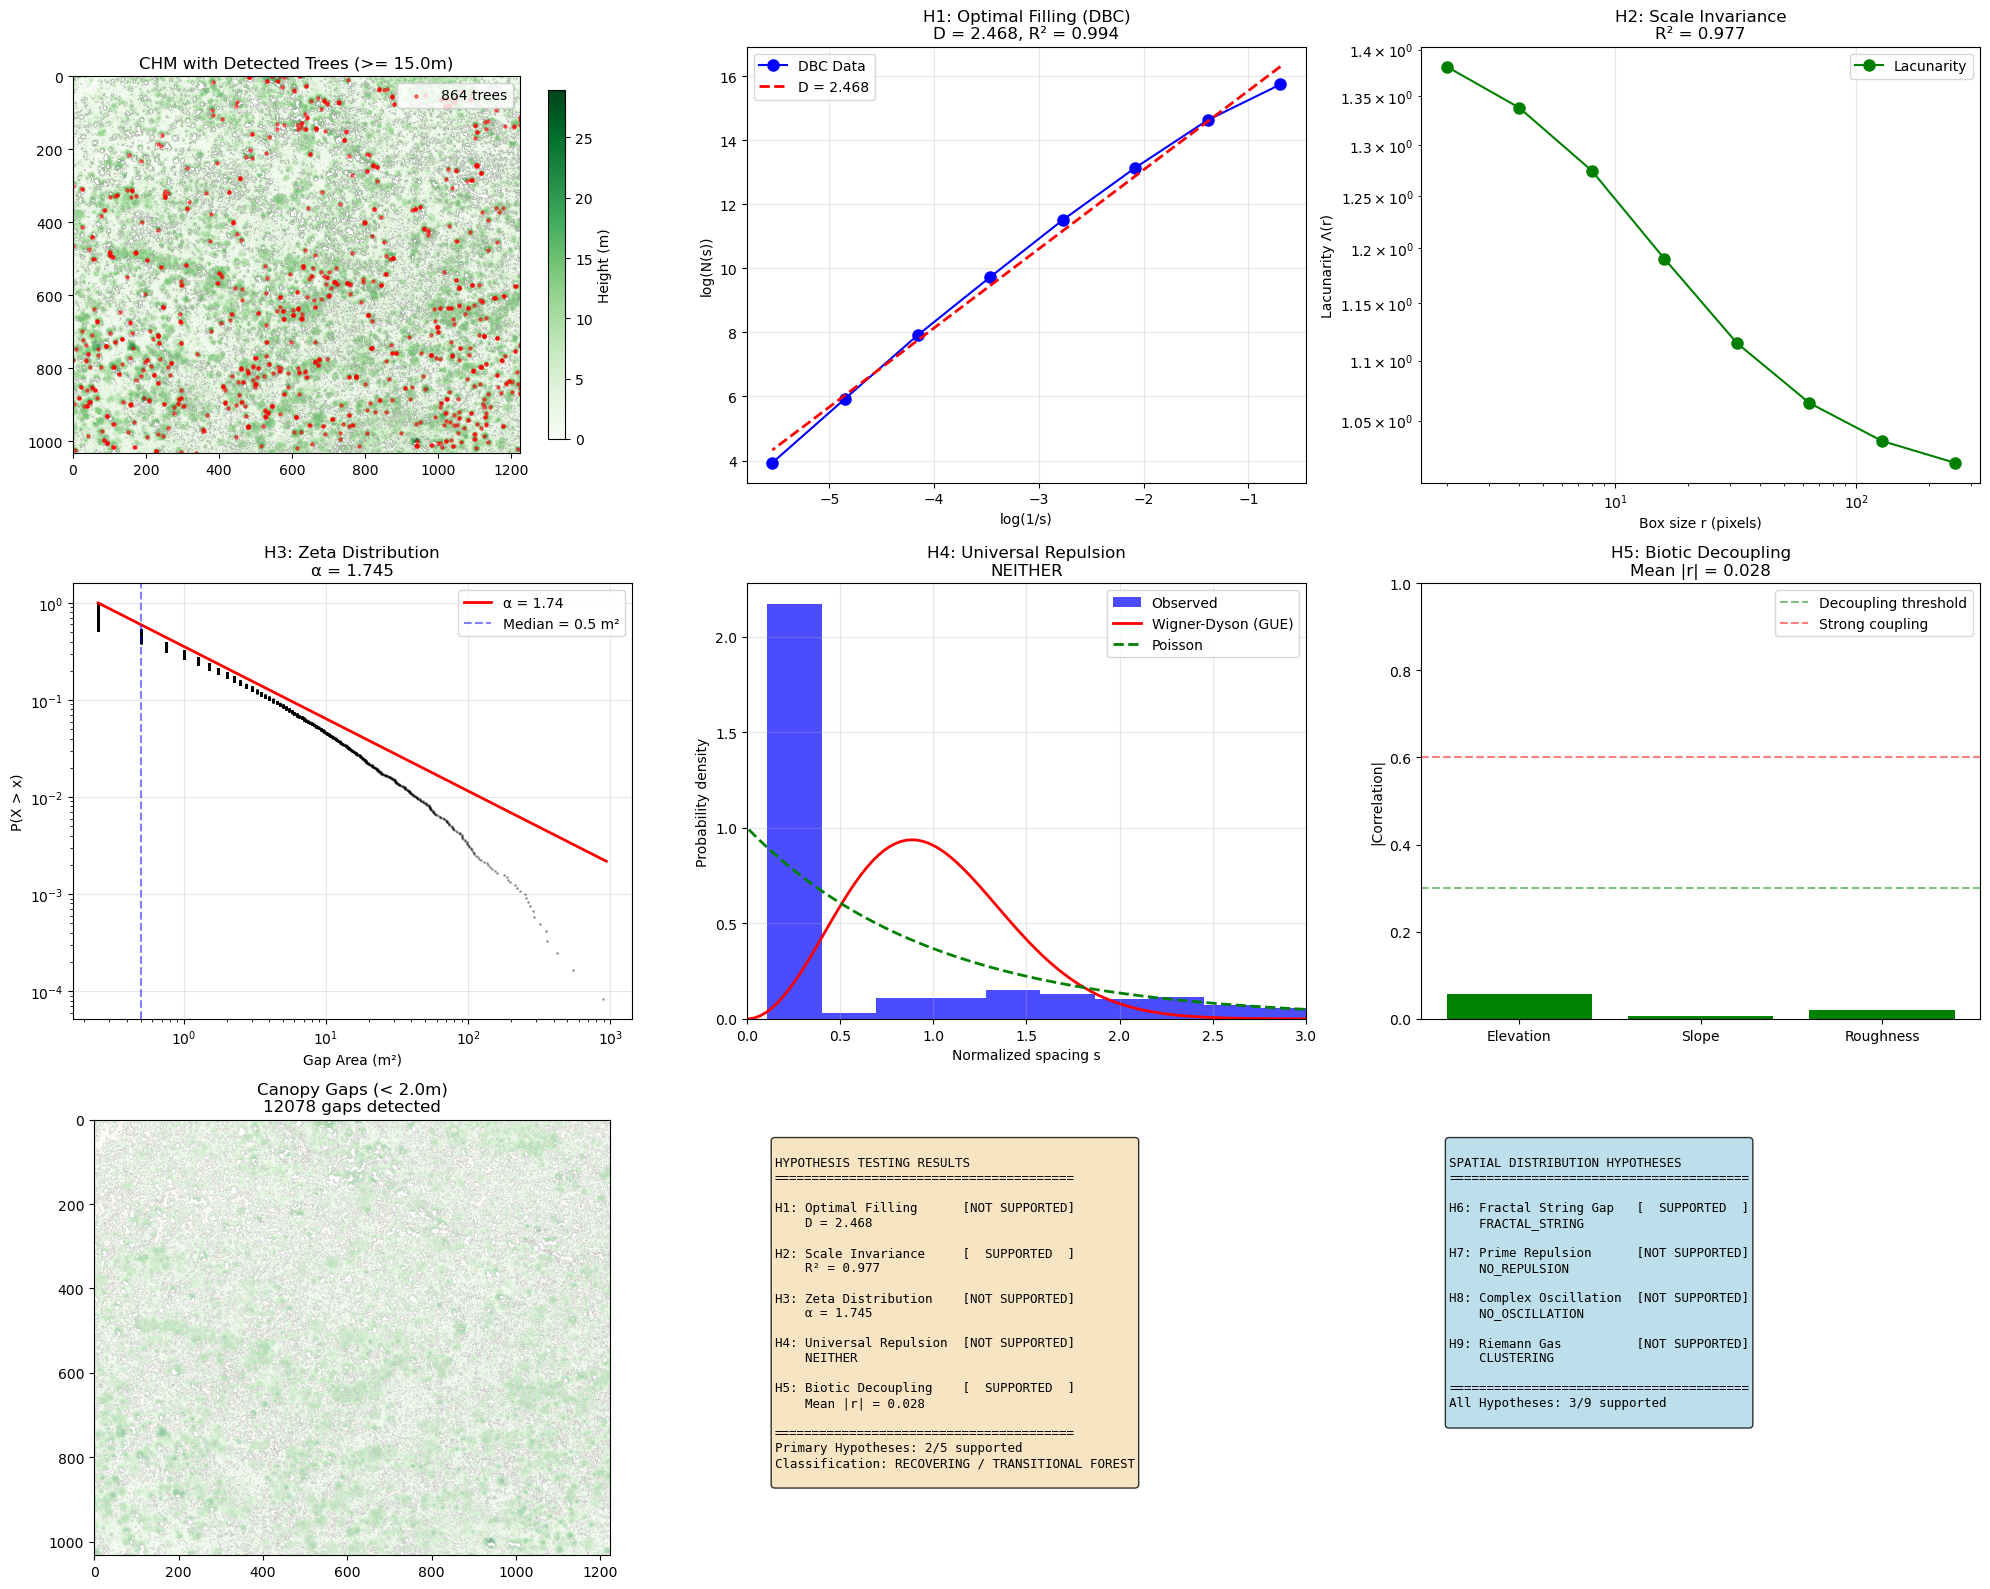

In [35]:
fig = plt.figure(figsize=(20, 16))

# 1. CHM with tree detections
ax1 = fig.add_subplot(3, 3, 1)
chm_display = np.ma.masked_where(~valid_mask, chm_array)
im1 = ax1.imshow(chm_display, cmap='Greens', vmin=0)
if len(tree_coords) > 0:
    ax1.scatter(tree_coords[:, 1], tree_coords[:, 0], c='red', s=5, alpha=0.5, label=f'{len(tree_coords)} trees')
ax1.set_title(f'CHM with Detected Trees (>= {DOMINANT_TREE_THRESHOLD}m)')
ax1.legend(loc='upper right')
plt.colorbar(im1, ax=ax1, label='Height (m)', shrink=0.8)

# 2. DBC log-log plot (H1)
ax2 = fig.add_subplot(3, 3, 2)
if len(scales_dbc) > 0:
    ax2.plot(np.log(1/scales_dbc), np.log(Ns_dbc), 'bo-', markersize=8, label='DBC Data')
    coeffs = np.polyfit(np.log(1/scales_dbc), np.log(Ns_dbc), 1)
    x_fit = np.log(1/scales_dbc)
    ax2.plot(x_fit, np.polyval(coeffs, x_fit), 'r--', linewidth=2, label=f'D = {D_dbc:.3f}')
ax2.set_xlabel('log(1/s)')
ax2.set_ylabel('log(N(s))')
ax2.set_title(f'H1: Optimal Filling (DBC)\nD = {D_dbc:.3f}, R² = {r2_dbc:.3f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Lacunarity plot (H2)
ax3 = fig.add_subplot(3, 3, 3)
if len(lac_sizes) > 0:
    ax3.loglog(lac_sizes, lacunarity, 'go-', markersize=8, label='Lacunarity')
    ax3.set_xlabel('Box size r (pixels)')
    ax3.set_ylabel('Lacunarity Λ(r)')
ax3.set_title(f'H2: Scale Invariance\nR² = {r2_lac:.3f}')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Gap size distribution (H3)
ax4 = fig.add_subplot(3, 3, 4)
if 'sorted_areas' in gap_results:
    ax4.loglog(gap_results['sorted_areas'], gap_results['ccdf'], 'k.', alpha=0.3, markersize=2)
    alpha = gap_results['power_law']['alpha']
    x_range = np.logspace(np.log10(gap_results['min_area']), np.log10(gap_results['max_area']), 100)
    y_pl = (x_range / gap_results['min_area']) ** (-(alpha - 1))
    ax4.loglog(x_range, y_pl, 'r-', linewidth=2, label=f'α = {alpha:.2f}')
    ax4.axvline(gap_results['median_area'], color='blue', linestyle='--', alpha=0.5, label=f'Median = {gap_results["median_area"]:.1f} m²')
ax4.set_xlabel('Gap Area (m²)')
ax4.set_ylabel('P(X > x)')
ax4.set_title(f'H3: Zeta Distribution\nα = {gap_results.get("power_law", {}).get("alpha", np.nan):.3f}')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Nearest neighbor spacing (H4)
ax5 = fig.add_subplot(3, 3, 5)
if 'spacings' in spacing_results and len(spacing_results.get('spacings', [])) > 0:
    spacings = spacing_results['spacings']
    ax5.hist(spacings, bins=30, density=True, alpha=0.7, color='blue', label='Observed')
    s_range = np.linspace(0.01, 3, 100)
    ax5.plot(s_range, wigner_dyson_gue(s_range), 'r-', linewidth=2, label='Wigner-Dyson (GUE)')
    ax5.plot(s_range, poisson_spacing(s_range), 'g--', linewidth=2, label='Poisson')
    ax5.set_xlim(0, 3)
ax5.set_xlabel('Normalized spacing s')
ax5.set_ylabel('Probability density')
ax5.set_title(f'H4: Universal Repulsion\n{h4_classification}')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Topographic correlation (H5)
ax6 = fig.add_subplot(3, 3, 6)
if 'correlations' in topo_results and len(topo_results['correlations']) > 0:
    # Build display from available correlations
    corr_names = []
    corr_values = []
    name_map = {
        'chm_roughness_vs_elevation': 'Elevation',
        'chm_roughness_vs_slope': 'Slope',
        'chm_roughness_vs_roughness': 'Roughness',
        'chm_roughness_vs_height': 'Height',
        'chm_roughness_vs_x_position': 'X-pos',
        'chm_roughness_vs_y_position': 'Y-pos'
    }
    for key, label in name_map.items():
        if key in topo_results['correlations']:
            corr_names.append(label)
            corr_values.append(abs(topo_results['correlations'][key]['r']))
    if corr_values:
        colors = ['green' if v < 0.3 else ('orange' if v < 0.6 else 'red') for v in corr_values]
        bars = ax6.bar(corr_names, corr_values, color=colors)
        ax6.axhline(0.3, color='green', linestyle='--', alpha=0.5, label='Decoupling threshold')
        ax6.axhline(0.6, color='red', linestyle='--', alpha=0.5, label='Strong coupling')
ax6.set_ylabel('|Correlation|')
ax6.set_title(f'H5: Biotic Decoupling\nMean |r| = {topo_results.get("mean_abs_correlation", np.nan):.3f}')
ax6.set_ylim(0, 1)
ax6.legend()

# 7. Gap labeled image
ax7 = fig.add_subplot(3, 3, 7)
gap_display = np.ma.masked_where(labeled_gaps == 0, labeled_gaps)
ax7.imshow(chm_display, cmap='Greens', vmin=0, alpha=0.5)
ax7.imshow(gap_display > 0, cmap='Reds', alpha=0.5)
ax7.set_title(f'Canopy Gaps (< {GAP_THRESHOLD}m)\n{gap_results.get("n_gaps", 0)} gaps detected')

# 8. Hypothesis support summary
ax8 = fig.add_subplot(3, 3, 8)
ax8.axis('off')

summary_text = f"""
HYPOTHESIS TESTING RESULTS
{"="*40}

H1: Optimal Filling      [{"SUPPORTED" if h1_results['supports_hypothesis'] else "NOT SUPPORTED":^13}]
    D = {D_dbc:.3f}

H2: Scale Invariance     [{"SUPPORTED" if h2_results['supports_hypothesis'] else "NOT SUPPORTED":^13}]
    R² = {r2_lac:.3f}

H3: Zeta Distribution    [{"SUPPORTED" if h3_results['supports_hypothesis'] else "NOT SUPPORTED":^13}]
    α = {gap_results.get('power_law', {}).get('alpha', np.nan):.3f}

H4: Universal Repulsion  [{"SUPPORTED" if h4_results['supports_hypothesis'] else "NOT SUPPORTED":^13}]
    {h4_classification}

H5: Biotic Decoupling    [{"SUPPORTED" if h5_results['supports_hypothesis'] else "NOT SUPPORTED":^13}]
    Mean |r| = {topo_results.get('mean_abs_correlation', np.nan):.3f}

{"="*40}
Primary Hypotheses: {primary_supported}/5 supported
Classification: {forest_class}
"""
ax8.text(0.05, 0.95, summary_text, transform=ax8.transAxes,
         fontsize=9, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 9. Spatial hypotheses summary
ax9 = fig.add_subplot(3, 3, 9)
ax9.axis('off')

spatial_text = f"""
SPATIAL DISTRIBUTION HYPOTHESES
{"="*40}

H6: Fractal String Gap   [{"SUPPORTED" if h6_results['supports_hypothesis'] else "NOT SUPPORTED":^13}]
    {h6_results['classification']}

H7: Prime Repulsion      [{"SUPPORTED" if h7_results['supports_hypothesis'] else "NOT SUPPORTED":^13}]
    {h7_results['classification']}

H8: Complex Oscillation  [{"SUPPORTED" if h8_results['supports_hypothesis'] else "NOT SUPPORTED":^13}]
    {h8_results['classification']}

H9: Riemann Gas          [{"SUPPORTED" if h9_results['supports_hypothesis'] else "NOT SUPPORTED":^13}]
    {h9_results['classification']}

{"="*40}
All Hypotheses: {supported_count}/9 supported
"""
ax9.text(0.05, 0.95, spatial_text, transform=ax9.transAxes,
         fontsize=9, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()

# Save figure
fig_path = OUTPUT_DIR / 'comprehensive_hypothesis_analysis.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"Figure saved to: {fig_path}")

plt.show()

---

# EXPORT RESULTS

In [36]:
# Compile all results
comprehensive_results = {
    'metadata': {
        'chm_path': str(CHM_PATH),
        'dem_path': str(DEM_PATH) if DEM_PATH else None,
        'analysis_date': datetime.now().isoformat(),
        'gap_threshold_m': GAP_THRESHOLD,
        'tree_height_threshold_m': DOMINANT_TREE_THRESHOLD,
        'pixel_resolution_m': pixel_resolution,
        'aoi_selected': selected_aoi['bounds_native'] is not None,
        'valid_pixels': int(valid_mask.sum()),
        'array_shape': list(chm_array.shape)
    },
    'hypotheses': {
        'H1_optimal_filling': h1_results,
        'H2_scale_invariance': h2_results,
        'H3_zeta_distribution': h3_results,
        'H4_universal_repulsion': h4_results,
        'H5_biotic_decoupling': h5_results,
        'H6_fractal_string_gap': h6_results,
        'H7_prime_repulsion': h7_results,
        'H8_complex_oscillation': h8_results,
        'H9_riemann_gas': h9_results
    },
    'summary': {
        'primary_hypotheses_supported': primary_supported,
        'all_hypotheses_supported': supported_count,
        'forest_classification': forest_class,
        'description': description
    },
    'key_metrics': {
        'dbc_fractal_dimension': float(D_dbc) if not np.isnan(D_dbc) else None,
        'dbc_r_squared': float(r2_dbc),
        'lacunarity_r_squared': float(r2_lac),
        'lacunarity_slope': float(lac_slope),
        'gap_power_law_alpha': float(gap_results.get('power_law', {}).get('alpha', np.nan)),
        'gap_power_law_r2': float(gap_results.get('power_law', {}).get('r2', 0)),
        'n_gaps': gap_results.get('n_gaps', 0),
        'n_dominant_trees': len(tree_coords),
        'mean_tree_spacing_m': float(mean_spacing) if not np.isnan(mean_spacing) else None,
        'topographic_mean_correlation': float(topo_results.get('mean_abs_correlation', np.nan))
    }
}

# Convert numpy types to Python types for JSON serialization
def convert_numpy(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj) if not np.isnan(obj) else None
    elif isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy(v) for v in obj]
    return obj

comprehensive_results = convert_numpy(comprehensive_results)

# Save to JSON
results_path = OUTPUT_DIR / 'comprehensive_hypothesis_results.json'
with open(results_path, 'w') as f:
    json.dump(comprehensive_results, f, indent=2, default=str)

print(f"Results saved to: {results_path}")
print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)

Results saved to: /home/jovyan/data-store/data/output/fractal_analysis/comprehensive_hypothesis_results.json

ANALYSIS COMPLETE


---

## References

### Fractal Dimension Methods
- Sarkar, N., & Chaudhuri, B.B. (1994). An efficient differential box-counting approach to compute fractal dimension of image. *IEEE Transactions on Systems, Man, and Cybernetics*.
- Allain, C., & Cloitre, M. (1991). Characterizing the lacunarity of random and deterministic fractal sets. *Physical Review A*.

### Ecological Applications
- West, G.B., Brown, J.H., & Enquist, B.J. (1997). A general model for the origin of allometric scaling laws in biology. *Science*.
- Mandelbrot, B.B. (1983). *The Fractal Geometry of Nature*. W.H. Freeman.

### Random Matrix Theory
- Wigner, E. (1955). Characteristic vectors of bordered matrices with infinite dimensions. *Annals of Mathematics*.
- Montgomery, H.L. (1973). The pair correlation of zeros of the zeta function. *Analytic Number Theory*.

### Fractal String Theory
- Lapidus, M.L., & van Frankenhuijsen, M. (2006). *Fractal Geometry, Complex Dimensions and Zeta Functions*. Springer.

### Research Framework
- See: https://tyson-swetnam.github.io/fractal-notebooks/hypotheses/abstract/